
# 🚪 Smart Gate Control System – Moroccan License Plate Recognition

This notebook builds a **license plate recognition pipeline** for a smart gate control system.

The pipeline follows **three main stages**:

1. **Vehicle detection** – detect cars using a pretrained YOLOv10 model.
2. **License plate detection** – detect the location of the plate using a finetuned YOLO model.
3. **Character recognition** – detect characters inside the plate and read them from left to right.

## Import Libraries & Mount Google Drive

In [116]:
# Install required packages
!pip install --upgrade kagglehub -q
!pip install ultralytics -q

# Import libraries
from pathlib import Path
from google.colab import drive
import kagglehub
import cv2 as cv
from matplotlib import pyplot as plt
import torch
from ultralytics import YOLO
from ultralytics.utils import LOGGER
import logging

# Suppress YOLO logging (only show errors)
LOGGER.setLevel(logging.ERROR)

In [117]:

mount_point = '/content/drive'

if Path(mount_point).is_dir and Path(f'{mount_point}/MyDrive').is_dir:
    print("✅ Google Drive is already mounted.")
else:
    print("🚀 Mounting Google Drive...")
    drive.mount(mount_point)

✅ Google Drive is already mounted.


## Paths & Dataset

In [118]:
# Project and model paths
PROJECT_PATH = Path('/content/drive/MyDrive/License plate Morocco')
model1_path = PROJECT_PATH / 'Models/yolov10n.pt'                # Vehicle detection model
model2_path = PROJECT_PATH / 'Models/license_plate_detector.pt'  # License plate detection model
model3_path = PROJECT_PATH / 'Models/PlateReaderyolo.pt'         # Character recognition model

# Download Moroccan plates dataset from Kaggle
moroccan_plates_folder_path = kagglehub.dataset_download("elmehditaf96/moroccan-vehicle-registration-plates")
moroccan_plates_folder_path = Path(moroccan_plates_folder_path) / 'dataset/dataset'

moroccan_plates_img_path = [img for img in moroccan_plates_folder_path.iterdir() if img.suffix == '.jpg']

##Preview the Dataset

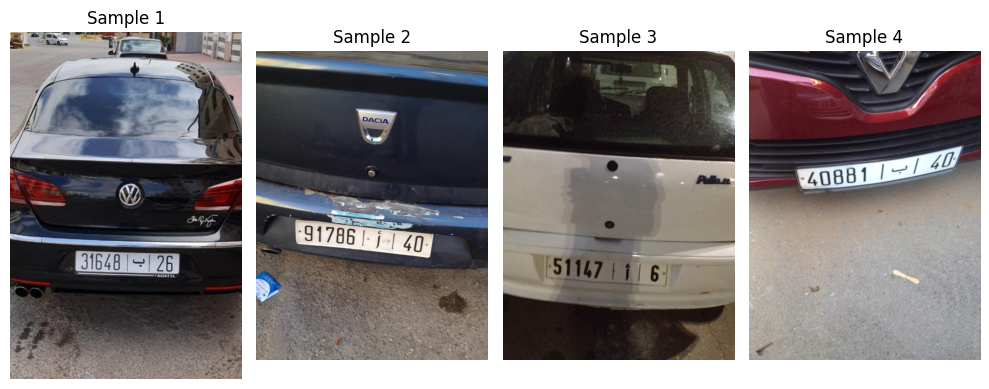

In [119]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
axes = axes.flatten()

for i, im_path in enumerate(moroccan_plates_img_path[:4]):
    img = cv.imread(str(im_path))
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].set_title(f"Sample {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

##Load Models

In [105]:
model1 = YOLO(str(model1_path))  # Vehicle detection
model2 = YOLO(str(model2_path))  # Plate detection
model3 = YOLO(str(model3_path))  # Character detection

##Stage 1: Detect Plates from Images

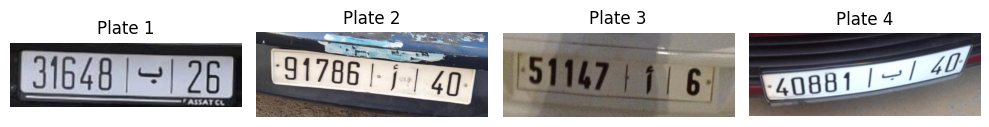

In [106]:
# Test plate detection on a few images
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
axes = axes.flatten()

for i, im_path in enumerate(moroccan_plates_img_path[:4]):
    img = cv.imread(str(im_path))

    # Detect plate
    result2 = model2(img)[0]
    x1, y1, x2, y2 = map(int, result2.boxes.xyxy.squeeze())
    plate = img[y1:y2, x1:x2]

    # Convert to RGB for plotting
    img_rgb = cv.cvtColor(plate, cv.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].set_title(f"Plate {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 6️⃣ Stage 2: Detect Characters in the Plate

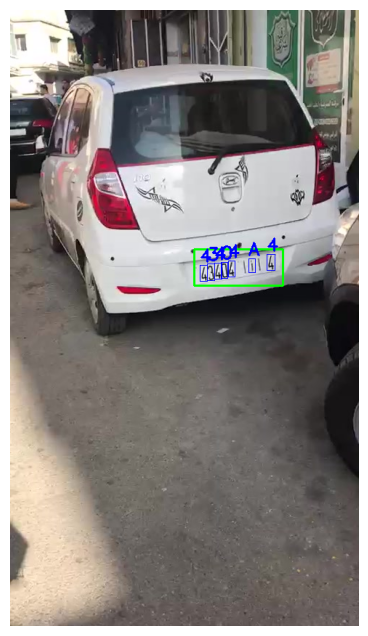

In [107]:
# Pick one test image
img = cv.imread(str(moroccan_plates_img_path[80]))

# --- Detect license plate ---
result2 = model2(img)[0]

# Mapping of YOLO class IDs → actual letters (for Moroccan plates)
cls_to_letter = {'10':'A','11':'B','12':'E','13':'D','14':'H'}

if not result2.boxes:
    print("No license plate detected. Cannot proceed with character detection.")
else:
    # Extract plate region
    x1_plate, y1_plate, x2_plate, y2_plate = map(int, result2.boxes.xyxy.squeeze())
    plate = img[y1_plate:y2_plate, x1_plate:x2_plate]

    # --- Detect characters inside plate ---
    result3 = model3(plate)[0]
    character_boxes_rel = result3.boxes.data.cpu().numpy()

    # Draw results
    img_with_boxes = cv.rectangle(img.copy(), (x1_plate, y1_plate), (x2_plate, y2_plate), (0, 255, 0), 2)

    for box in character_boxes_rel:
        x1_char_rel, y1_char_rel, x2_char_rel, y2_char_rel, conf, cls = map(int, box)

        # Convert relative to absolute coordinates
        x1_char_abs = x1_plate + x1_char_rel
        y1_char_abs = y1_plate + y1_char_rel
        x2_char_abs = x1_plate + x2_char_rel
        y2_char_abs = y1_plate + y2_char_rel

        # Draw bounding box for character
        cv.rectangle(img_with_boxes,
                     (x1_char_abs, y1_char_abs),
                     (x2_char_abs, y2_char_abs),
                     (255, 0, 0), 1)

        # Decode character class
        cls_name = result3.names.get(cls)
        if cls_name in cls_to_letter:
            cls_name = cls_to_letter[cls_name]

        # Draw text above the box
        cv.putText(img_with_boxes, str(cls_name),
                   (x1_char_abs, y1_char_abs - 5),
                   cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # Convert BGR → RGB and display
    img_with_boxes_rgb = cv.cvtColor(img_with_boxes, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(img_with_boxes_rgb)
    plt.axis('off')
    plt.show()


##4. Full End-to-End Pipeline: Plate & Character Recognition


No license plate detected on one of the cars.
No license plate detected on one of the cars.


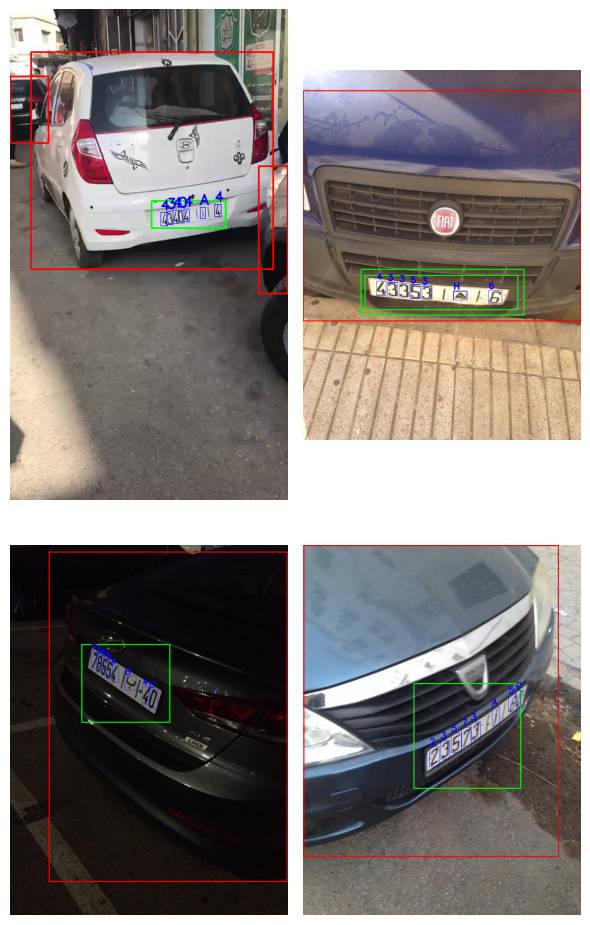

In [113]:
def process_and_visualize_image(img_path, models, cls_to_letter_map):

    img = cv.imread(str(img_path))
    if img is None:
        print(f"Error: Could not read image at {img_path}")
        return None

    img_with_boxes = img.copy()

    # --- Stage 0: Detect all cars ---
    result1 = models['model1'](img)[0]

    if not result1.boxes:
        print("No car detected.")
        # Return the original image if no cars are found
        return cv.cvtColor(img_with_boxes, cv.COLOR_BGR2RGB)
    else:
        # Iterate through all detected cars
        for car_box in result1.boxes.xyxy:
            x1_car, y1_car, x2_car, y2_car = map(int, car_box.squeeze())

            # --- DRAW THE CAR BOUNDING BOX ---
            cv.rectangle(img_with_boxes, (x1_car, y1_car), (x2_car, y2_car), (0, 0, 255), 2)

            # --- Stage 1: Detect the license plate within the car's bounding box ---
            car_roi = img[y1_car:y2_car, x1_car:x2_car]
            result2 = models['model2'](car_roi)[0]

            if not result2.boxes:
                print("No license plate detected on one of the cars.")
            else:
                # Iterate through all detected license plates on the current car
                for plate_box in result2.boxes.xyxy:
                    x1_plate_rel, y1_plate_rel, x2_plate_rel, y2_plate_rel = map(int, plate_box.squeeze())

                    # Translate plate coordinates to original image frame
                    x1_plate_abs = x1_car + x1_plate_rel
                    y1_plate_abs = y1_car + y1_plate_rel
                    x2_plate_abs = x1_car + x2_plate_rel
                    y2_plate_abs = y1_car + y2_plate_rel

                    # Draw the license plate bounding box
                    cv.rectangle(img_with_boxes, (x1_plate_abs, y1_plate_abs), (x2_plate_abs, y2_plate_abs), (0, 255, 0), 2)

                    # Crop the license plate region for character detection
                    plate = img[y1_plate_abs:y2_plate_abs, x1_plate_abs:x2_plate_abs]

                    # --- Stage 2: Detect characters within the license plate ---
                    result3 = models['model3'](plate)[0]
                    character_boxes = result3.boxes.data.cpu().numpy()

                    # Loop through each character detected
                    for char_box in character_boxes:
                        x1_char_rel, y1_char_rel, x2_char_rel, y2_char_rel, conf, cls = char_box

                        # Translate character box coordinates to the original image's coordinate system
                        x1_char_abs = int(x1_plate_abs + x1_char_rel)
                        y1_char_abs = int(y1_plate_abs + y1_char_rel)
                        x2_char_abs = int(x1_plate_abs + x2_char_rel)
                        y2_char_abs = int(y1_plate_abs + y2_char_rel)

                        # Get the class label from the cls_to_letter mapping
                        cls_name = result3.names.get(int(cls))
                        text_to_display = cls_to_letter_map.get(str(cls_name), str(cls_name))

                        # Draw the character bounding box and text
                        cv.rectangle(img_with_boxes, (x1_char_abs, y1_char_abs), (x2_char_abs, y2_char_abs), (255, 0, 0), 1)
                        cv.putText(img_with_boxes, text_to_display, (x1_char_abs, y1_char_abs - 5), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    return cv.cvtColor(img_with_boxes, cv.COLOR_BGR2RGB)



# 5

No license plate detected on one of the cars.
No license plate detected on one of the cars.


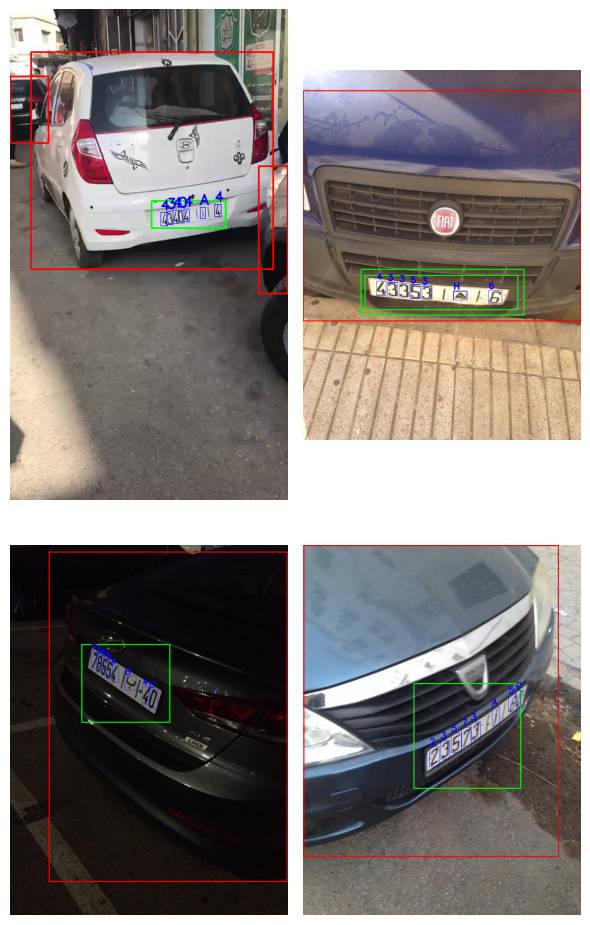

In [114]:

models = {
    'model1': model1,
    'model2': model2,
    'model3': model3
}
cls_to_letter = {'10':'A','11':'B', '12':'E','13':'D', '14':'H'}


selected_images_paths = moroccan_plates_img_path[80:84]

processed_images = []
for path in selected_images_paths:
    processed_image = process_and_visualize_image(path, models, cls_to_letter)
    if processed_image is not None:
        processed_images.append(processed_image)

fig, axes = plt.subplots(2, 2, figsize=(6, 10))
axes = axes.flatten()

for i, img in enumerate(processed_images):
    axes[i].imshow(img)
    axes[i].set_title(f'')
    axes[i].axis('off')

plt.tight_layout()
plt.show()